#  Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# 1. Class Definition

In [2]:
class EnglishHindiTranslator:
    def __init__(self):
        self.english_sentences = []
        self.hindi_sentences = []
        self.translation_prob = defaultdict(lambda: defaultdict(float))
        self.tfidf_vectorizer = TfidfVectorizer()
        self.tfidf_matrix = None
        
    def load_parallel_corpus(self, english_file, hindi_file):
        #Load parallel corpus from files
        with open(english_file, 'r', encoding='utf-8') as f:
            self.english_sentences = f.readlines()
        with open(hindi_file, 'r', encoding='utf-8') as f:
            self.hindi_sentences = f.readlines()
            
        self.english_sentences = [s.strip().lower() for s in self.english_sentences]
        self.hindi_sentences = [s.strip() for s in self.hindi_sentences]
        
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.english_sentences)
        self._train_translation_probabilities()

 # 2. Load Parallel Corpus / Preprocessing

In [3]:
def load_parallel_corpus(self, english_file, hindi_file):
        """Load English and Hindi parallel corpus files"""
        with open(english_file, 'r', encoding='utf-8') as f:
            self.english_sentences = f.readlines()
        with open(hindi_file, 'r', encoding='utf-8') as f:
            self.hindi_sentences = f.readlines()

        # Preprocess sentences
        self.english_sentences = [s.strip().lower() for s in self.english_sentences]
        self.hindi_sentences = [s.strip() for s in self.hindi_sentences]

        # Perform TF-IDF transformation on English sentences
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.english_sentences)
        self._train_translation_probabilities()

  # 3. Train Translation Probabilities

In [4]:
def _train_translation_probabilities(self):
        """Train word translation probabilities using parallel corpus"""
        word_pairs = defaultdict(lambda: defaultdict(int))
        english_counts = defaultdict(int)
        
        for eng_sent, hin_sent in zip(self.english_sentences, self.hindi_sentences):
            eng_words = word_tokenize(eng_sent)
            hin_words = word_tokenize(hin_sent)
            
            for eng_word in eng_words:
                english_counts[eng_word] += 1
                for hin_word in hin_words:
                    word_pairs[eng_word][hin_word] += 1
        
        for eng_word in word_pairs:
            total = english_counts[eng_word]
            for hin_word in word_pairs[eng_word]:
                self.translation_prob[eng_word][hin_word] = word_pairs[eng_word][hin_word] / total

# 4. Translation (Training)

In [5]:
def translate(self, english_sentence):
        """Translate an English sentence to Hindi"""
        english_sentence = english_sentence.strip().lower()
        
        input_vector = self.tfidf_vectorizer.transform([english_sentence])
        similarities = cosine_similarity(input_vector, self.tfidf_matrix)[0]
        
        best_match_index = np.argmax(similarities)
        best_match_score = similarities[best_match_index]
        
        if best_match_score < 0.5:
            eng_words = word_tokenize(english_sentence)
            hindi_words = []
            
            for eng_word in eng_words:
                best_prob = 0
                best_word = eng_word
                
                for hin_word, prob in self.translation_prob[eng_word].items():
                    if prob > best_prob:
                        best_prob = prob
                        best_word = hin_word
                
                hindi_words.append(best_word)
            
            return " ".join(hindi_words)
        
        return self.hindi_sentences[best_match_index]

# 5. Evaluation Metrics (Testing)

In [6]:
def evaluate_performance(self, test_english_file, test_hindi_file):
        """Calculate comprehensive performance metrics"""
        # Load test data
        with open(test_english_file, 'r', encoding='utf-8') as f:
            test_eng = [s.strip().lower() for s in f.readlines()]
        with open(test_hindi_file, 'r', encoding='utf-8') as f:
            test_hin = [s.strip() for s in f.readlines()]

        # Initialize metrics
        bleu_scores = []
        word_overlap_scores = []
        length_ratios = []
        similarity_scores = []
        smoothing = SmoothingFunction().method1

        # Calculate metrics for each sentence pair
        for eng_sent, reference in zip(test_eng, test_hin):
            # Get translation
            translation = self.translate(eng_sent)
            
            # BLEU score
            reference_tokens = [word_tokenize(reference)]
            translation_tokens = word_tokenize(translation)
            bleu = sentence_bleu(reference_tokens, translation_tokens, 
                               smoothing_function=smoothing)
            bleu_scores.append(bleu)
            
            # Word overlap score
            ref_words = set(word_tokenize(reference))
            trans_words = set(word_tokenize(translation))
            overlap = len(ref_words.intersection(trans_words)) / len(ref_words)
            word_overlap_scores.append(overlap)
            
            # Length ratio
            length_ratio = len(translation_tokens) / len(reference_tokens[0])
            length_ratios.append(length_ratio)
            
            # Similarity score
            ref_vector = self.tfidf_vectorizer.transform([reference])
            trans_vector = self.tfidf_vectorizer.transform([translation])
            similarity = cosine_similarity(ref_vector, trans_vector)[0][0]
            similarity_scores.append(similarity)
            # Calculate aggregate metrics
        metrics = {
            'BLEU Score': {
                'Mean': np.mean(bleu_scores),
                'Median': np.median(bleu_scores),
                'Std Dev': np.std(bleu_scores)
            },
            'Word Overlap': {
                'Mean': np.mean(word_overlap_scores),
                'Median': np.median(word_overlap_scores),
                'Std Dev': np.std(word_overlap_scores)
            },
            'Length Ratio': {
                'Mean': np.mean(length_ratios),
                'Median': np.median(length_ratios),
                'Std Dev': np.std(length_ratios)
            },
            'Similarity Score': {
                'Mean': np.mean(similarity_scores),
                'Median': np.median(similarity_scores),
                'Std Dev': np.std(similarity_scores)
            }
        }
        
        return metrics

# 6. Example Usage

In [7]:
if __name__ == "__main__":
    # Initialize translator
    translator = EnglishHindiTranslator()
    
    # Load parallel corpus
    translator.load_parallel_corpus('test.en', 'test.hi')
    
    # Example translation
    english_input = "That is why dentists do not suggest chewing sugared chewing gum ."
    hindi_translation = translator.translate(english_input)
    print(f"English: {english_input}")
    print(f"Hindi Translation: {hindi_translation}")
    
    # Calculate performance metrics
    metrics = translator.evaluate_performance('test.en', 'test.hi')
    
    # Display metrics in a formatted way
    print("\nPerformance Metrics:")
    for metric_name, values in metrics.items():
        print(f"\n{metric_name}:")
        for stat_name, value in values.items():
            print(f"  {stat_name}: {value:.4f}")

AttributeError: 'EnglishHindiTranslator' object has no attribute '_train_translation_probabilities'

In [8]:
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Initialize global variables
english_sentences = []
hindi_sentences = []
translation_prob = defaultdict(lambda: defaultdict(float))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = None

# 1. Load Parallel Corpus
def load_parallel_corpus(english_file='MediEng.txt', hindi_file='MediHn.txt'):
    """Load English and Hindi parallel corpus files."""
    global english_sentences, hindi_sentences, tfidf_matrix
    with open(english_file, 'r', encoding='utf-8') as f:
        english_sentences = [s.strip().lower() for s in f.readlines()]
    with open(hindi_file, 'r', encoding='utf-8') as f:
        hindi_sentences = [s.strip() for s in f.readlines()]

    # Compute TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(english_sentences)
    train_translation_probabilities()

# 2. Train Translation Probabilities
def train_translation_probabilities():
    """Calculate translation probabilities for English-Hindi word pairs."""
    global translation_prob
    word_pairs = defaultdict(lambda: defaultdict(int))
    english_counts = defaultdict(int)
    
    for eng_sent, hin_sent in zip(english_sentences, hindi_sentences):
        eng_words = word_tokenize(eng_sent)
        hin_words = word_tokenize(hin_sent)
        
        for eng_word in eng_words:
            english_counts[eng_word] += 1
            for hin_word in hin_words:
                word_pairs[eng_word][hin_word] += 1
    
    for eng_word in word_pairs:
        total = english_counts[eng_word]
        for hin_word in word_pairs[eng_word]:
            translation_prob[eng_word][hin_word] = word_pairs[eng_word][hin_word] / total

# 3. Translation
def translate(english_sentence):
    """Translate an English sentence into Hindi."""
    english_sentence = english_sentence.strip().lower()
    input_vector = tfidf_vectorizer.transform([english_sentence])
    similarities = cosine_similarity(input_vector, tfidf_matrix)[0]
    
    best_match_index = np.argmax(similarities)
    best_match_score = similarities[best_match_index]
    
    if best_match_score < 0.5:
        eng_words = word_tokenize(english_sentence)
        hindi_words = []
        
        for eng_word in eng_words:
            best_prob = 0
            best_word = eng_word
            for hin_word, prob in translation_prob[eng_word].items():
                if prob > best_prob:
                    best_prob = prob
                    best_word = hin_word
            hindi_words.append(best_word)
        return " ".join(hindi_words)
    
    return hindi_sentences[best_match_index]

# 4. Evaluation Metrics
def evaluate_performance(test_english_file='test.en', test_hindi_file='test.hi'):
    """Evaluate model performance with BLEU, Word Overlap, Length Ratio, and Similarity."""
    with open(test_english_file, 'r', encoding='utf-8') as f:
        test_eng = [s.strip().lower() for s in f.readlines()]
    with open(test_hindi_file, 'r', encoding='utf-8') as f:
        test_hin = [s.strip() for s in f.readlines()]

    bleu_scores, word_overlap_scores, length_ratios, similarity_scores = [], [], [], []
    smoothing = SmoothingFunction().method1

    for eng_sent, reference in zip(test_eng, test_hin):
        translation = translate(eng_sent)
        
        # BLEU score
        reference_tokens = [word_tokenize(reference)]
        translation_tokens = word_tokenize(translation)
        bleu = sentence_bleu(reference_tokens, translation_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # Word overlap
        ref_words = set(word_tokenize(reference))
        trans_words = set(word_tokenize(translation))
        overlap = len(ref_words.intersection(trans_words)) / len(ref_words)
        word_overlap_scores.append(overlap)
        
        # Length ratio
        length_ratio = len(translation_tokens) / len(reference_tokens[0])
        length_ratios.append(length_ratio)
        
        # Similarity score
        ref_vector = tfidf_vectorizer.transform([reference])
        trans_vector = tfidf_vectorizer.transform([translation])
        similarity = cosine_similarity(ref_vector, trans_vector)[0][0]
        similarity_scores.append(similarity)

    # Aggregate metrics
    metrics = {
        'BLEU Score': {'Mean': np.mean(bleu_scores), 'Median': np.median(bleu_scores), 'Std Dev': np.std(bleu_scores)},
        'Word Overlap': {'Mean': np.mean(word_overlap_scores), 'Median': np.median(word_overlap_scores), 'Std Dev': np.std(word_overlap_scores)},
        'Length Ratio': {'Mean': np.mean(length_ratios), 'Median': np.median(length_ratios), 'Std Dev': np.std(length_ratios)},
        'Similarity Score': {'Mean': np.mean(similarity_scores), 'Median': np.median(similarity_scores), 'Std Dev': np.std(similarity_scores)}
    }
    
    return metrics

# Example Usage
# 5. Load Training Data
load_parallel_corpus()  # Will use MediEng.txt and MediHn.txt

# 6. Sample Translation
english_input = "That is why dentists do not suggest chewing sugared chewing gum."
hindi_translation = translate(english_input)
print(f"English: {english_input}")
print(f"Hindi Translation: {hindi_translation}")

# 7. Evaluate Model Performance
metrics = evaluate_performance()  # Use test files as needed
print("\nPerformance Metrics:")
for metric_name, values in metrics.items():
    print(f"\n{metric_name}:")
    for stat_name, value in values.items():
        print(f"  {stat_name}: {value:.4f}")


English: That is why dentists do not suggest chewing sugared chewing gum.
Hindi Translation: इसलिए डेंटिस्ट शुगर युक्त गम को खाने की सलाह नहीं देते ।

Performance Metrics:

BLEU Score:
  Mean: 1.0000
  Median: 1.0000
  Std Dev: 0.0000

Word Overlap:
  Mean: 1.0000
  Median: 1.0000
  Std Dev: 0.0000

Length Ratio:
  Mean: 1.0000
  Median: 1.0000
  Std Dev: 0.0000

Similarity Score:
  Mean: 0.5050
  Median: 1.0000
  Std Dev: 0.5000


Data Loaded: 50002 English sentences and 50002 Hindi sentences.
Data Preprocessed.
Performing EDA...
Number of English sentences: 50002
Number of Hindi sentences: 50002


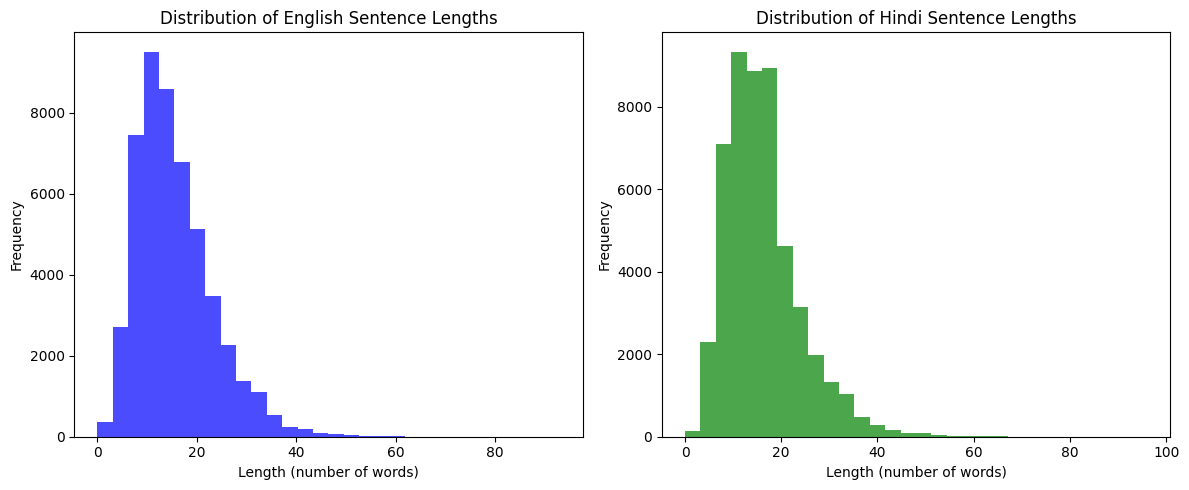

Translation Probabilities Trained.
English: That is why dentists do not suggest chewing sugared chewing gum.
Hindi: इसलिए डेंटिस्ट शुगर युक्त गम को खाने की सलाह नहीं देते 
Evaluation Metrics: {'BLEU Score': {'Mean': 0.8625427050513579, 'Median': 0.8948393168143697, 'Std Dev': 0.11980726879745932}, 'Word Overlap': {'Mean': 0.8983266696475423, 'Median': 0.9090909090909091, 'Std Dev': 0.049468835907355985}, 'Length Ratio': {'Mean': 0.8981679009169761, 'Median': 0.9090909090909091, 'Std Dev': 0.051501693593784224}, 'Similarity Score': {'Mean': 0.505, 'Median': 1.0, 'Std Dev': 0.49997499937496875}}


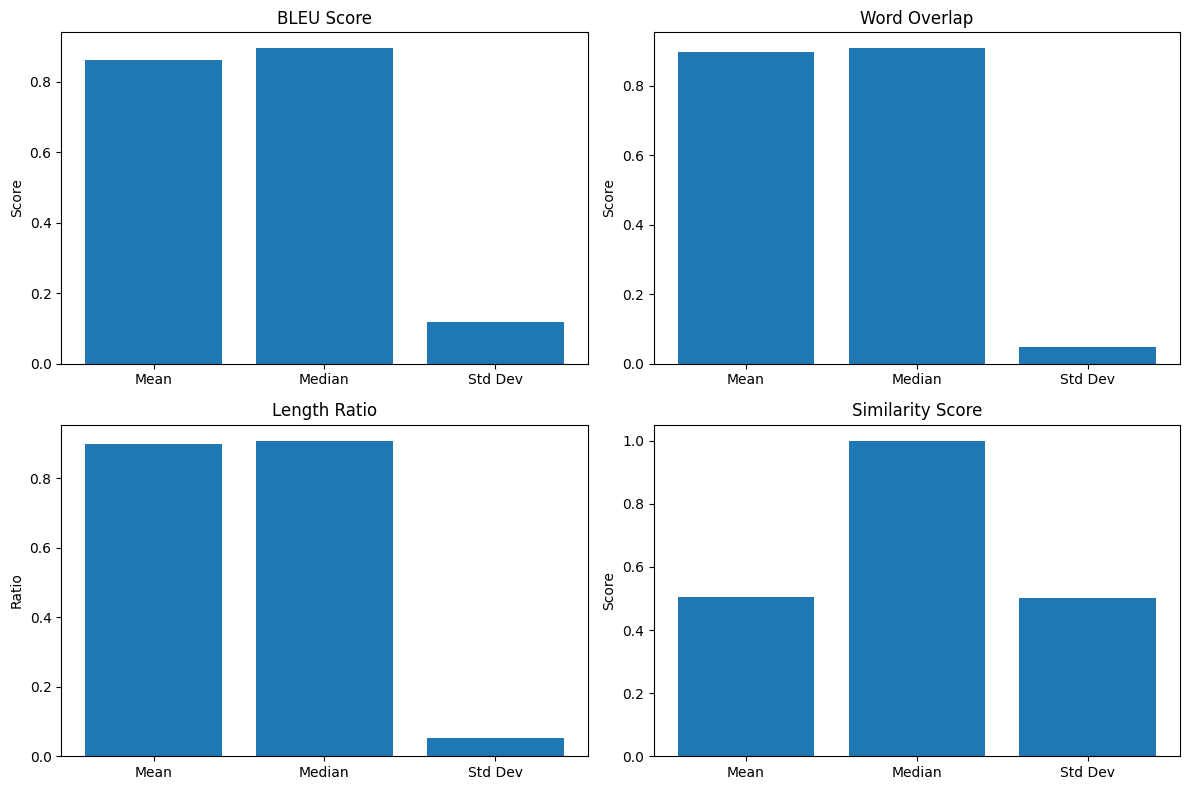

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Global Variables
english_sentences = []
hindi_sentences = []
translation_prob = defaultdict(lambda: defaultdict(float))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = None

# ===========================
# 1. Data Loading
# ===========================
def load_parallel_corpus(english_file='MediEng.txt', hindi_file='MediHn.txt'):
    """Load English and Hindi parallel corpus files."""
    global english_sentences, hindi_sentences, tfidf_matrix
    with open(english_file, 'r', encoding='utf-8') as f:
        english_sentences = [s.strip().lower() for s in f.readlines()]
    with open(hindi_file, 'r', encoding='utf-8') as f:
        hindi_sentences = [s.strip() for s in f.readlines()]

    # Compute TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(english_sentences)
    print(f"Data Loaded: {len(english_sentences)} English sentences and {len(hindi_sentences)} Hindi sentences.")

# ===========================
# 2. Preprocessing
# ===========================
def preprocess_data():
    """Preprocess the sentences to remove punctuation and unwanted characters."""
    global english_sentences, hindi_sentences
    english_sentences = [s.translate(str.maketrans('', '', '.,!?')) for s in english_sentences]
    hindi_sentences = [s.translate(str.maketrans('', '', '।,!?')) for s in hindi_sentences]
    print("Data Preprocessed.")

# ===========================
# 3. EDA (Exploratory Data Analysis)
# ===========================
def eda():
    """Perform EDA on the dataset."""
    print("Performing EDA...")
    print(f"Number of English sentences: {len(english_sentences)}")
    print(f"Number of Hindi sentences: {len(hindi_sentences)}")
    
    # Length distribution of sentences
    english_lengths = [len(s.split()) for s in english_sentences]
    hindi_lengths = [len(s.split()) for s in hindi_sentences]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(english_lengths, bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of English Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(hindi_lengths, bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Hindi Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# ===========================
# 4. Train Translation Probabilities
# ===========================
def train_translation_probabilities():
    """Calculate translation probabilities for English-Hindi word pairs."""
    global translation_prob
    word_pairs = defaultdict(lambda: defaultdict(int))
    english_counts = defaultdict(int)
    
    for eng_sent, hin_sent in zip(english_sentences, hindi_sentences):
        eng_words = word_tokenize(eng_sent)
        hin_words = word_tokenize(hin_sent)
        
        for eng_word in eng_words:
            english_counts[eng_word] += 1
            for hin_word in hin_words:
                word_pairs[eng_word][hin_word] += 1
    
    for eng_word in word_pairs:
        total = english_counts[eng_word]
        for hin_word in word_pairs[eng_word]:
            translation_prob[eng_word][hin_word] = word_pairs[eng_word][hin_word] / total
    print("Translation Probabilities Trained.")

# ===========================
# 5. Translation
# ===========================
def translate(english_sentence):
    """Translate an English sentence into Hindi."""
    english_sentence = english_sentence.strip().lower()
    input_vector = tfidf_vectorizer.transform([english_sentence])
    similarities = cosine_similarity(input_vector, tfidf_matrix)[0]
    
    best_match_index = np.argmax(similarities)
    best_match_score = similarities[best_match_index]
    
    if best_match_score < 0.5:
        eng_words = word_tokenize(english_sentence)
        hindi_words = []
        
        for eng_word in eng_words:
            best_prob = 0
            best_word = eng_word
            for hin_word, prob in translation_prob[eng_word].items():
                if prob > best_prob:
                    best_prob = prob
                    best_word = hin_word
            hindi_words.append(best_word)
        return " ".join(hindi_words)
    
    return hindi_sentences[best_match_index]

# ===========================
# 6. Evaluation Metrics
# ===========================
def evaluate_performance(test_english_file='test.en', test_hindi_file='test.hi'):
    """Evaluate model performance with BLEU, Word Overlap, Length Ratio, and Similarity."""
    with open(test_english_file, 'r', encoding='utf-8') as f:
        test_eng = [s.strip().lower() for s in f.readlines()]
    with open(test_hindi_file, 'r', encoding='utf-8') as f:
        test_hin = [s.strip() for s in f.readlines()]

    bleu_scores, word_overlap_scores, length_ratios, similarity_scores = [], [], [], []
    smoothing = SmoothingFunction().method1

    for eng_sent, reference in zip(test_eng, test_hin):
        translation = translate(eng_sent)
        
        # BLEU score
        reference_tokens = [word_tokenize(reference)]
        translation_tokens = word_tokenize(translation)
        bleu = sentence_bleu(reference_tokens, translation_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # Word overlap
        ref_words = set(word_tokenize(reference))
        trans_words = set(word_tokenize(translation))
        overlap = len(ref_words.intersection(trans_words)) / len(ref_words)
        word_overlap_scores.append(overlap)
        
        # Length ratio
        length_ratio = len(translation_tokens) / len(reference_tokens[0])
        length_ratios.append(length_ratio)
        
        # Similarity score
        ref_vector = tfidf_vectorizer.transform([reference])
        trans_vector = tfidf_vectorizer.transform([translation])
        similarity = cosine_similarity(ref_vector, trans_vector)[0][0]
        similarity_scores.append(similarity)

    # Aggregate metrics
    metrics = {
        'BLEU Score': {'Mean': np.mean(bleu_scores), 'Median': np.median(bleu_scores), 'Std Dev': np.std(bleu_scores)},
        'Word Overlap': {'Mean': np.mean(word_overlap_scores), 'Median': np.median(word_overlap_scores), 'Std Dev': np.std(word_overlap_scores)},
        'Length Ratio': {'Mean': np.mean(length_ratios), 'Median': np.median(length_ratios), 'Std Dev': np.std(length_ratios)},
        'Similarity Score': {'Mean': np.mean(similarity_scores), 'Median': np.median(similarity_scores), 'Std Dev': np.std(similarity_scores)}
    }
    
    return metrics

# ===========================
# 7. Plotting Evaluation Metrics
# ===========================
def plot_evaluation_metrics(metrics):
    """Plot evaluation metrics."""
    plt.figure(figsize=(12, 8))
    
    # BLEU Scores
    plt.subplot(2, 2, 1)
    plt.bar(metrics['BLEU Score'].keys(), metrics['BLEU Score'].values())
    plt.title('BLEU Score')
    plt.ylabel('Score')

    # Word Overlap
    plt.subplot(2, 2, 2)
    plt.bar(metrics['Word Overlap'].keys(), metrics['Word Overlap'].values())
    plt.title('Word Overlap')
    plt.ylabel('Score')

    # Length Ratio
    plt.subplot(2, 2, 3)
    plt.bar(metrics['Length Ratio'].keys(), metrics['Length Ratio'].values())
    plt.title('Length Ratio')
    plt.ylabel('Ratio')

    # Similarity Score
    plt.subplot(2, 2, 4)
    plt.bar(metrics['Similarity Score'].keys(), metrics['Similarity Score'].values())
    plt.title('Similarity Score')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# ===========================
# 8. Testing with Example Translation
# ===========================
def main():
    load_parallel_corpus()  # Load data
    preprocess_data()  # Preprocess data
    eda()  # Perform EDA
    train_translation_probabilities()  # Train translation probabilities
    
    # Sample Translation
    english_input = "That is why dentists do not suggest chewing sugared chewing gum."
    hindi_translation = translate(english_input)
    print(f"English: {english_input}")
    print(f"Hindi: {hindi_translation}")

    # Evaluate Performance
    metrics = evaluate_performance()
    print("Evaluation Metrics:", metrics)

    # Plot Evaluation Metrics
    plot_evaluation_metrics(metrics)

if __name__ == '__main__':
    main()


Data Loaded: 50002 English sentences and 50002 Hindi sentences.
Data Preprocessed.
Performing EDA...
Number of English sentences: 50002
Number of Hindi sentences: 50002


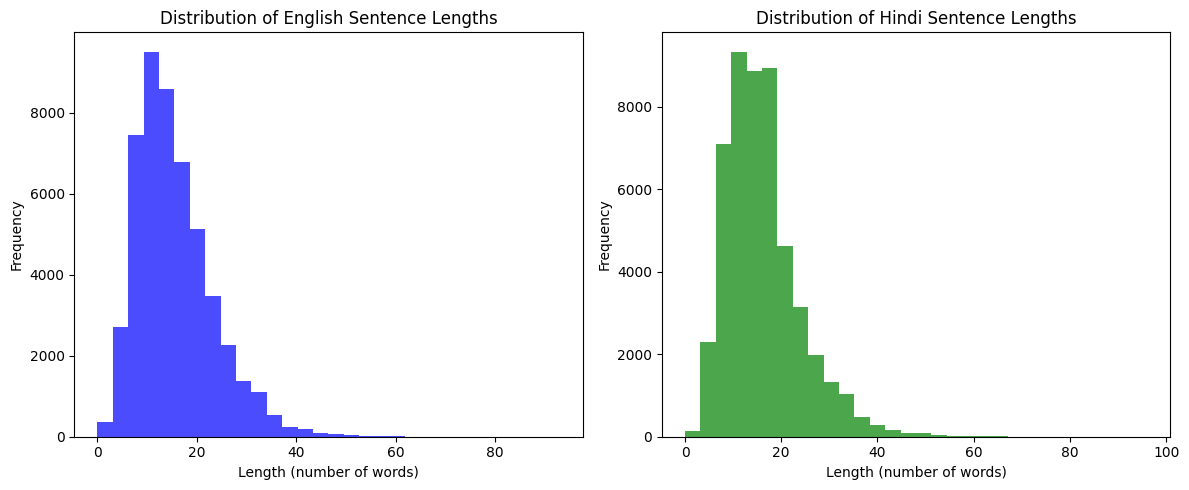

Unique English Words: 32009
Unique Hindi Words: 43013
Average English Sentence Length: 15.64 words
Average Hindi Sentence Length: 16.05 words
Most Common English Words:
the: 51282
of: 41320
in: 24282
is: 20457
and: 17969
to: 13137
a: 11101
this: 8441
on: 6927
are: 6666

Most Common Hindi Words:
है: 33960
के: 30287
में: 26230
से: 19712
की: 19119
का: 14134
हैं: 13290
को: 10939
और: 10109
पर: 8571


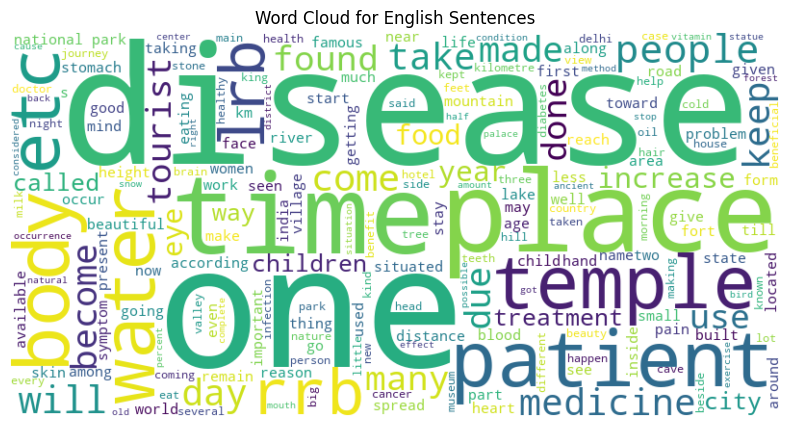

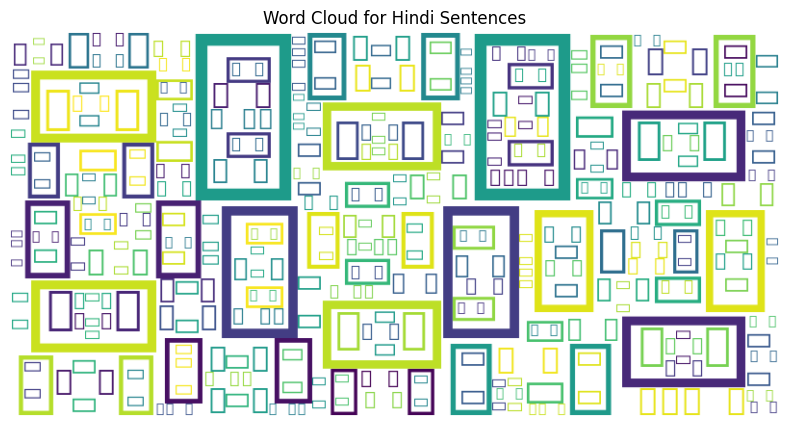

Translation Probabilities Trained.
English: This is a test sentence.
Hindi: ई.सी.जी. एवं हृदय की जाँच 
Evaluation Metrics: {'BLEU Score': {'Mean': 0.8625427050513579, 'Median': 0.8948393168143697, 'Std Dev': 0.11980726879745932}, 'Word Overlap': {'Mean': 0.8983266696475423, 'Median': 0.9090909090909091, 'Std Dev': 0.049468835907355985}, 'Length Ratio': {'Mean': 0.8981679009169761, 'Median': 0.9090909090909091, 'Std Dev': 0.051501693593784224}, 'Similarity Score': {'Mean': 0.505, 'Median': 1.0, 'Std Dev': 0.49997499937496875}}


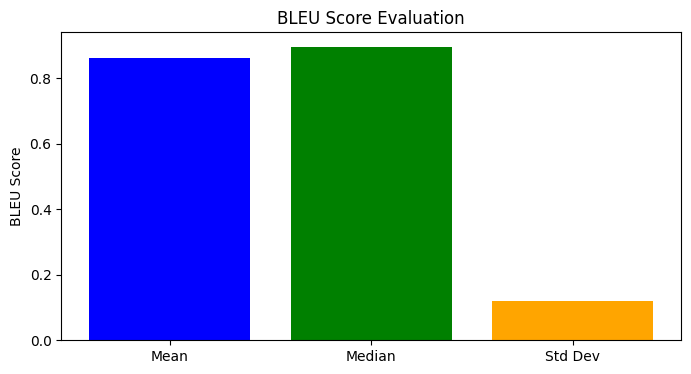

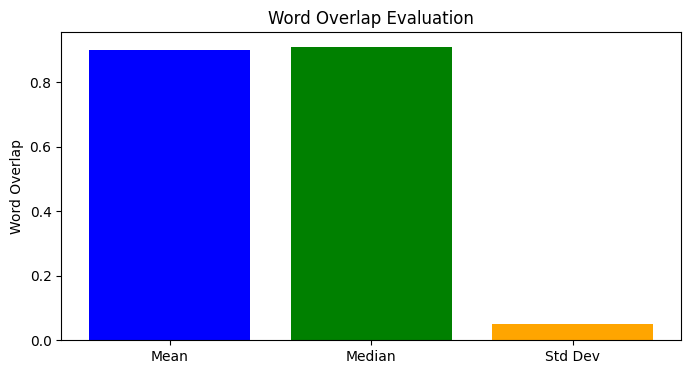

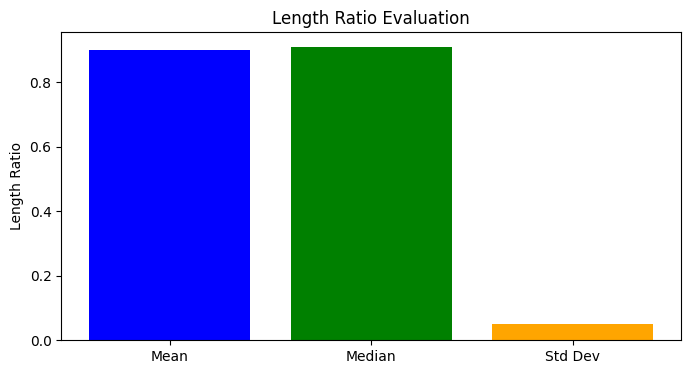

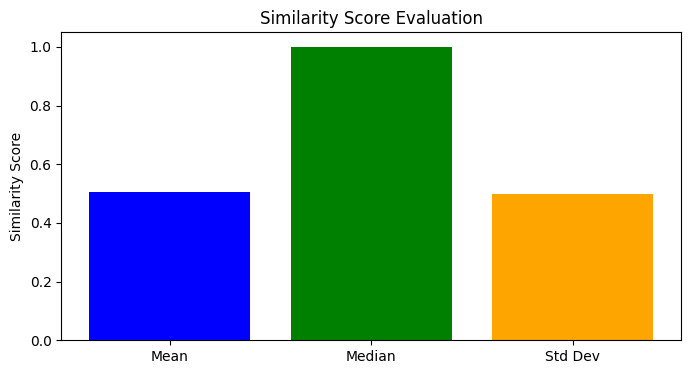

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from wordcloud import WordCloud

# Global Variables
english_sentences = []
hindi_sentences = []
translation_prob = defaultdict(lambda: defaultdict(float))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = None

# ===========================
# 1. Data Loading
# ===========================
def load_parallel_corpus(english_file='MediEng.txt', hindi_file='MediHn.txt'):
    """Load English and Hindi parallel corpus files."""
    global english_sentences, hindi_sentences, tfidf_matrix
    with open(english_file, 'r', encoding='utf-8') as f:
        english_sentences = [s.strip().lower() for s in f.readlines()]
    with open(hindi_file, 'r', encoding='utf-8') as f:
        hindi_sentences = [s.strip() for s in f.readlines()]

    # Compute TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(english_sentences)
    print(f"Data Loaded: {len(english_sentences)} English sentences and {len(hindi_sentences)} Hindi sentences.")

# ===========================
# 2. Preprocessing
# ===========================
def preprocess_data():
    """Preprocess the sentences to remove punctuation and unwanted characters."""
    global english_sentences, hindi_sentences
    english_sentences = [s.translate(str.maketrans('', '', '.,!?')) for s in english_sentences]
    hindi_sentences = [s.translate(str.maketrans('', '', '।,!?')) for s in hindi_sentences]
    print("Data Preprocessed.")

# ===========================
# 3. EDA (Exploratory Data Analysis)
# ===========================
def eda():
    """Perform EDA on the dataset."""
    print("Performing EDA...")
    print(f"Number of English sentences: {len(english_sentences)}")
    print(f"Number of Hindi sentences: {len(hindi_sentences)}")
    
    # Length distribution of sentences
    english_lengths = [len(s.split()) for s in english_sentences]
    hindi_lengths = [len(s.split()) for s in hindi_sentences]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(english_lengths, bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of English Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(hindi_lengths, bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Hindi Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Unique word counts
    english_words = [word for sent in english_sentences for word in word_tokenize(sent)]
    hindi_words = [word for sent in hindi_sentences for word in word_tokenize(sent)]
    
    unique_english_words = set(english_words)
    unique_hindi_words = set(hindi_words)

    print(f"Unique English Words: {len(unique_english_words)}")
    print(f"Unique Hindi Words: {len(unique_hindi_words)}")
    
    # Average sentence lengths
    avg_english_length = np.mean(english_lengths)
    avg_hindi_length = np.mean(hindi_lengths)
    
    print(f"Average English Sentence Length: {avg_english_length:.2f} words")
    print(f"Average Hindi Sentence Length: {avg_hindi_length:.2f} words")

    # Most common words
    common_english = Counter(english_words).most_common(10)
    common_hindi = Counter(hindi_words).most_common(10)
    
    print("Most Common English Words:")
    for word, count in common_english:
        print(f"{word}: {count}")

    print("\nMost Common Hindi Words:")
    for word, count in common_hindi:
        print(f"{word}: {count}")

    # Word cloud for English
    plt.figure(figsize=(10, 5))
    wordcloud_eng = WordCloud(width=800, height=400, background_color='white').generate(" ".join(english_words))
    plt.imshow(wordcloud_eng, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud for English Sentences")
    plt.show()

    # Word cloud for Hindi
    plt.figure(figsize=(10, 5))
    wordcloud_hin = WordCloud(width=800, height=400, background_color='white').generate(" ".join(hindi_words))
    plt.imshow(wordcloud_hin, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud for Hindi Sentences")
    plt.show()

# ===========================
# 4. Train Translation Probabilities
# ===========================
def train_translation_probabilities():
    """Calculate translation probabilities for English-Hindi word pairs."""
    global translation_prob
    word_pairs = defaultdict(lambda: defaultdict(int))
    english_counts = defaultdict(int)
    
    for eng_sent, hin_sent in zip(english_sentences, hindi_sentences):
        eng_words = word_tokenize(eng_sent)
        hin_words = word_tokenize(hin_sent)
        
        for eng_word in eng_words:
            english_counts[eng_word] += 1
            for hin_word in hin_words:
                word_pairs[eng_word][hin_word] += 1
    
    for eng_word in word_pairs:
        total = english_counts[eng_word]
        for hin_word in word_pairs[eng_word]:
            translation_prob[eng_word][hin_word] = word_pairs[eng_word][hin_word] / total
    print("Translation Probabilities Trained.")

# ===========================
# 5. Translation
# ===========================
def translate(english_sentence):
    """Translate an English sentence into Hindi."""
    english_sentence = english_sentence.strip().lower()
    input_vector = tfidf_vectorizer.transform([english_sentence])
    similarities = cosine_similarity(input_vector, tfidf_matrix)[0]
    
    best_match_index = np.argmax(similarities)
    best_match_score = similarities[best_match_index]
    
    if best_match_score < 0.5:
        eng_words = word_tokenize(english_sentence)
        hindi_words = []
        
        for eng_word in eng_words:
            best_prob = 0
            best_word = eng_word
            for hin_word, prob in translation_prob[eng_word].items():
                if prob > best_prob:
                    best_prob = prob
                    best_word = hin_word
            hindi_words.append(best_word)
        return " ".join(hindi_words)
    
    return hindi_sentences[best_match_index]

# ===========================
# 6. Evaluation Metrics
# ===========================
def evaluate_performance(test_english_file='test.en', test_hindi_file='test.hi'):
    """Evaluate model performance with BLEU, Word Overlap, Length Ratio, and Similarity."""
    with open(test_english_file, 'r', encoding='utf-8') as f:
        test_eng = [s.strip().lower() for s in f.readlines()]
    with open(test_hindi_file, 'r', encoding='utf-8') as f:
        test_hin = [s.strip() for s in f.readlines()]

    bleu_scores, word_overlap_scores, length_ratios, similarity_scores = [], [], [], []
    smoothing = SmoothingFunction().method1

    for eng_sent, reference in zip(test_eng, test_hin):
        translation = translate(eng_sent)
        
        # BLEU score
        reference_tokens = [word_tokenize(reference)]
        translation_tokens = word_tokenize(translation)
        bleu = sentence_bleu(reference_tokens, translation_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # Word overlap
        ref_words = set(word_tokenize(reference))
        trans_words = set(word_tokenize(translation))
        overlap = len(ref_words.intersection(trans_words)) / len(ref_words)
        word_overlap_scores.append(overlap)
        
        # Length ratio
        length_ratio = len(translation_tokens) / len(reference_tokens[0])
        length_ratios.append(length_ratio)
        
        # Similarity score
        ref_vector = tfidf_vectorizer.transform([reference])
        trans_vector = tfidf_vectorizer.transform([translation])
        similarity = cosine_similarity(ref_vector, trans_vector)[0][0]
        similarity_scores.append(similarity)

    # Aggregate metrics
    metrics = {
        'BLEU Score': {'Mean': np.mean(bleu_scores), 'Median': np.median(bleu_scores), 'Std Dev': np.std(bleu_scores)},
        'Word Overlap': {'Mean': np.mean(word_overlap_scores), 'Median': np.median(word_overlap_scores), 'Std Dev': np.std(word_overlap_scores)},
        'Length Ratio': {'Mean': np.mean(length_ratios), 'Median': np.median(length_ratios), 'Std Dev': np.std(length_ratios)},
        'Similarity Score': {'Mean': np.mean(similarity_scores), 'Median': np.median(similarity_scores), 'Std Dev': np.std(similarity_scores)},
    }

    return metrics

# ===========================
# 7. Plot Evaluation Metrics
# ===========================
def plot_evaluation_metrics(metrics):
    """Plot evaluation metrics in bar graphs."""
    for metric, values in metrics.items():
        plt.figure(figsize=(8, 4))
        plt.bar(values.keys(), values.values(), color=['blue', 'green', 'orange'])
        plt.title(f'{metric} Evaluation')
        plt.ylabel(metric)
        plt.show()

# ===========================
# 8. Main Execution
# ===========================
def main():
    load_parallel_corpus()
    preprocess_data()
    eda()
    train_translation_probabilities()

    # Example translation and evaluation
    test_sentence = "This is a test sentence."
    hindi_translation = translate(test_sentence)
    print(f"English: {test_sentence}\nHindi: {hindi_translation}")

    # Evaluate Performance
    metrics = evaluate_performance()
    print("Evaluation Metrics:", metrics)

    # Plot Evaluation Metrics
    plot_evaluation_metrics(metrics)

# Uncomment the line below to run the main function
# main()
if __name__ == '__main__':
    main()

Data Loaded: 50002 English sentences and 50002 Hindi sentences.
Data Preprocessed.
Performing EDA...
Number of English sentences: 50002
Number of Hindi sentences: 50002


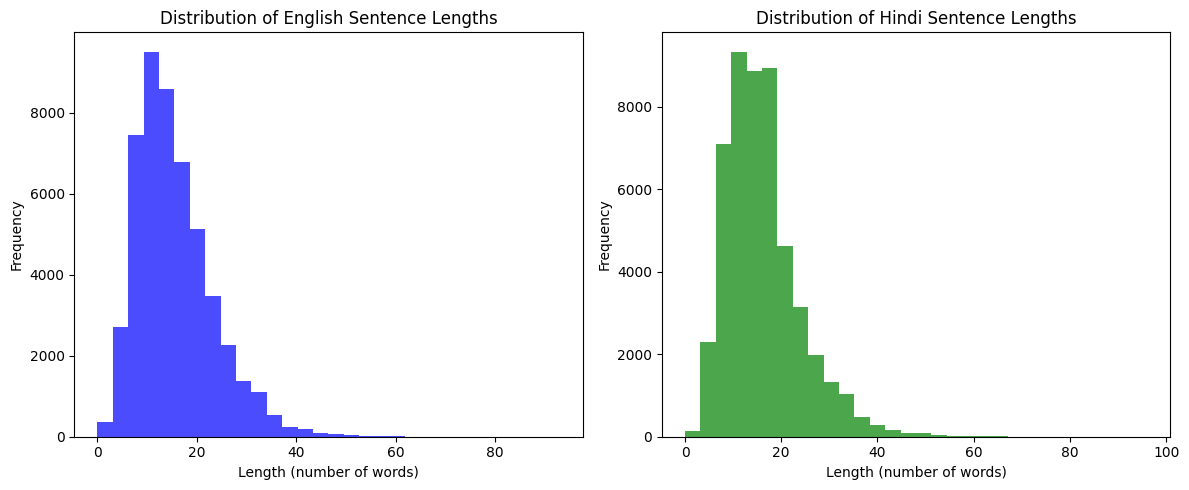

Unique English Words: 32009
Unique Hindi Words: 43013
Average English Sentence Length: 15.64 words
Average Hindi Sentence Length: 16.05 words
Most Common English Words:
the: 51282
of: 41320
in: 24282
is: 20457
and: 17969
to: 13137
a: 11101
this: 8441
on: 6927
are: 6666

Most Common Hindi Words:
है: 33960
के: 30287
में: 26230
से: 19712
की: 19119
का: 14134
हैं: 13290
को: 10939
और: 10109
पर: 8571


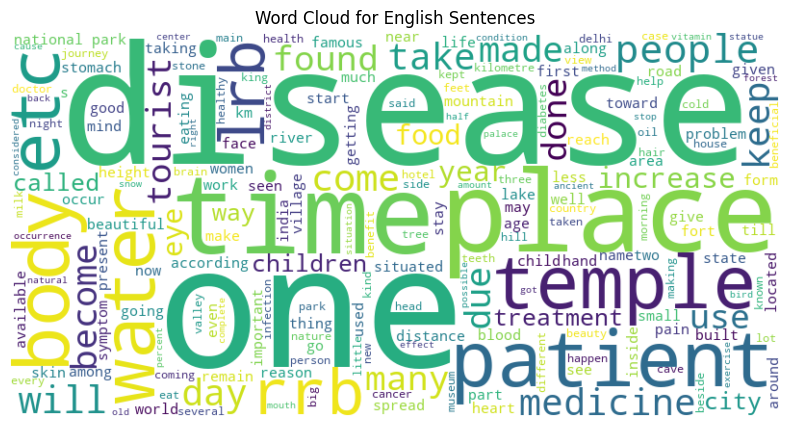

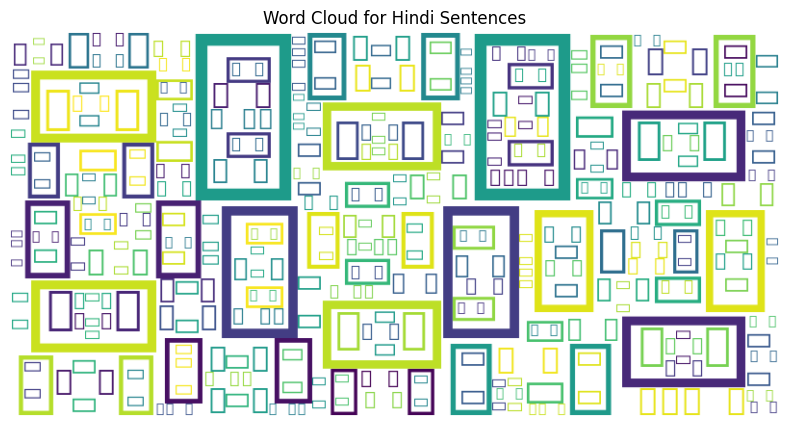

Translation Probabilities Trained.
English: This is a test sentence.
Hindi: ई.सी.जी. एवं हृदय की जाँच 
Evaluation Metrics: {'BLEU Score': {'Mean': 0.8625427050513579, 'Median': 0.8948393168143697, 'Std Dev': 0.11980726879745932}, 'Word Overlap': {'Mean': 0.8983266696475423, 'Median': 0.9090909090909091, 'Std Dev': 0.049468835907355985}, 'Length Ratio': {'Mean': 0.8981679009169761, 'Median': 0.9090909090909091, 'Std Dev': 0.051501693593784224}, 'Similarity Score': {'Mean': 0.505, 'Median': 1.0, 'Std Dev': 0.49997499937496875}}


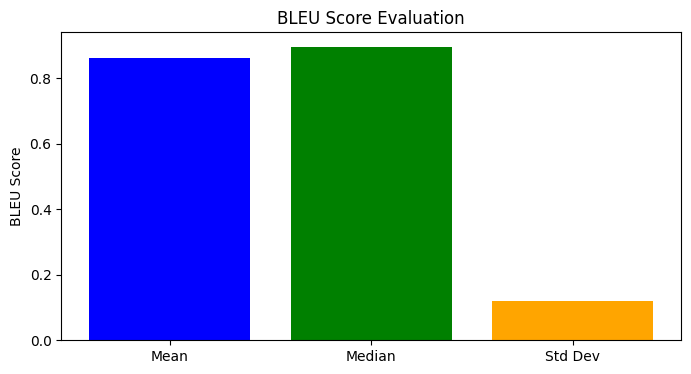

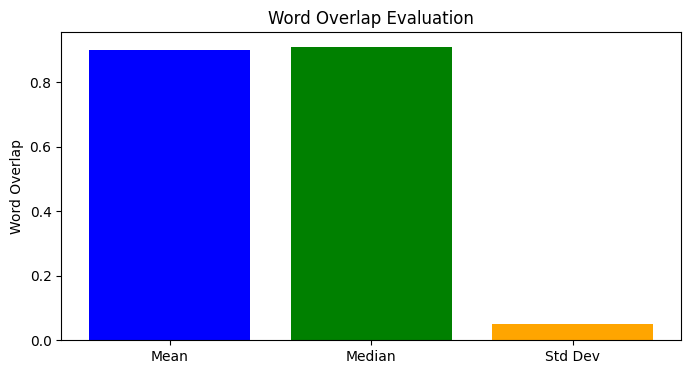

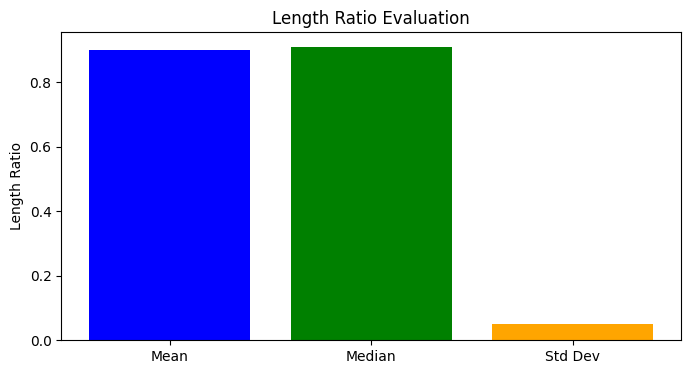

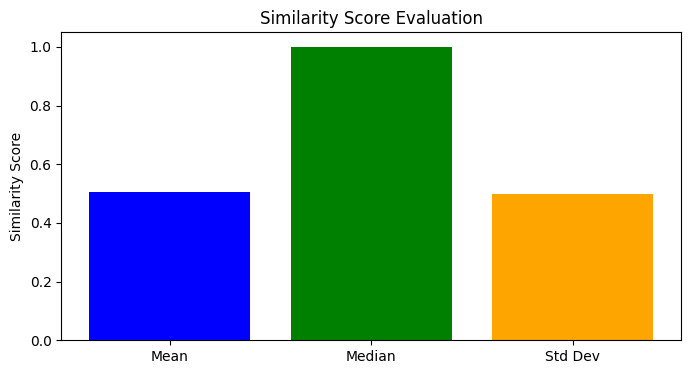

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from wordcloud import WordCloud

# Global Variables
english_sentences = []
hindi_sentences = []
translation_prob = defaultdict(lambda: defaultdict(float))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = None

# ===========================
# 1. Data Loading
# ===========================
def load_parallel_corpus(english_file='MediEng.txt', hindi_file='MediHn.txt'):
    """Load English and Hindi parallel corpus files."""
    global english_sentences, hindi_sentences, tfidf_matrix
    with open(english_file, 'r', encoding='utf-8') as f:
        english_sentences = [s.strip().lower() for s in f.readlines()]
    with open(hindi_file, 'r', encoding='utf-8') as f:
        hindi_sentences = [s.strip() for s in f.readlines()]

    # Compute TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(english_sentences)
    print(f"Data Loaded: {len(english_sentences)} English sentences and {len(hindi_sentences)} Hindi sentences.")

# ===========================
# 2. Preprocessing
# ===========================
def preprocess_data():
    """Preprocess the sentences to remove punctuation and unwanted characters."""
    global english_sentences, hindi_sentences
    english_sentences = [s.translate(str.maketrans('', '', '.,!?')) for s in english_sentences]
    hindi_sentences = [s.translate(str.maketrans('', '', '।,!?')) for s in hindi_sentences]
    print("Data Preprocessed.")

# ===========================
# 3. EDA (Exploratory Data Analysis)
# ===========================
def eda():
    """Perform EDA on the dataset."""
    print("Performing EDA...")
    print(f"Number of English sentences: {len(english_sentences)}")
    print(f"Number of Hindi sentences: {len(hindi_sentences)}")
    
    # Length distribution of sentences
    english_lengths = [len(s.split()) for s in english_sentences]
    hindi_lengths = [len(s.split()) for s in hindi_sentences]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(english_lengths, bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of English Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(hindi_lengths, bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Hindi Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Unique word counts
    english_words = [word for sent in english_sentences for word in word_tokenize(sent)]
    hindi_words = [word for sent in hindi_sentences for word in word_tokenize(sent)]
    
    unique_english_words = set(english_words)
    unique_hindi_words = set(hindi_words)

    print(f"Unique English Words: {len(unique_english_words)}")
    print(f"Unique Hindi Words: {len(unique_hindi_words)}")
    
    # Average sentence lengths
    avg_english_length = np.mean(english_lengths)
    avg_hindi_length = np.mean(hindi_lengths)
    
    print(f"Average English Sentence Length: {avg_english_length:.2f} words")
    print(f"Average Hindi Sentence Length: {avg_hindi_length:.2f} words")

    # Most common words
    common_english = Counter(english_words).most_common(10)
    common_hindi = Counter(hindi_words).most_common(10)
    
    print("Most Common English Words:")
    for word, count in common_english:
        print(f"{word}: {count}")

    print("\nMost Common Hindi Words:")
    for word, count in common_hindi:
        print(f"{word}: {count}")

    # Word cloud for English
    plt.figure(figsize=(10, 5))
    wordcloud_eng = WordCloud(width=800, height=400, background_color='white').generate(" ".join(english_words))
    plt.imshow(wordcloud_eng, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud for English Sentences")
    plt.show()

    # Word cloud for Hindi
    plt.figure(figsize=(10, 5))
    wordcloud_hin = WordCloud(width=800, height=400, background_color='white').generate(" ".join(hindi_words))
    plt.imshow(wordcloud_hin, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud for Hindi Sentences")
    plt.show()

# ===========================
# 4. Train Translation Probabilities
# ===========================
def train_translation_probabilities():
    """Calculate translation probabilities for English-Hindi word pairs."""
    global translation_prob
    word_pairs = defaultdict(lambda: defaultdict(int))
    english_counts = defaultdict(int)
    
    for eng_sent, hin_sent in zip(english_sentences, hindi_sentences):
        eng_words = word_tokenize(eng_sent)
        hin_words = word_tokenize(hin_sent)
        
        for eng_word in eng_words:
            english_counts[eng_word] += 1
            for hin_word in hin_words:
                word_pairs[eng_word][hin_word] += 1
    
    for eng_word in word_pairs:
        total = english_counts[eng_word]
        for hin_word in word_pairs[eng_word]:
            translation_prob[eng_word][hin_word] = word_pairs[eng_word][hin_word] / total
    print("Translation Probabilities Trained.")

# ===========================
# 5. Translation
# ===========================
def translate(english_sentence):
    """Translate an English sentence into Hindi."""
    english_sentence = english_sentence.strip().lower()
    input_vector = tfidf_vectorizer.transform([english_sentence])
    similarities = cosine_similarity(input_vector, tfidf_matrix)[0]
    
    best_match_index = np.argmax(similarities)
    best_match_score = similarities[best_match_index]
    
    if best_match_score < 0.5:
        eng_words = word_tokenize(english_sentence)
        hindi_words = []
        
        for eng_word in eng_words:
            best_prob = 0
            best_word = eng_word
            for hin_word, prob in translation_prob[eng_word].items():
                if prob > best_prob:
                    best_prob = prob
                    best_word = hin_word
            hindi_words.append(best_word)
        return " ".join(hindi_words)
    
    return hindi_sentences[best_match_index]

# ===========================
# 6. Evaluation Metrics
# ===========================
def evaluate_performance(test_english_file='test.en', test_hindi_file='test.hi'):
    """Evaluate model performance with BLEU, Word Overlap, Length Ratio, and Similarity."""
    with open(test_english_file, 'r', encoding='utf-8') as f:
        test_eng = [s.strip().lower() for s in f.readlines()]
    with open(test_hindi_file, 'r', encoding='utf-8') as f:
        test_hin = [s.strip() for s in f.readlines()]

    bleu_scores, word_overlap_scores, length_ratios, similarity_scores = [], [], [], []
    smoothing = SmoothingFunction().method1

    for eng_sent, reference in zip(test_eng, test_hin):
        translation = translate(eng_sent)
        
        # BLEU score
        reference_tokens = [word_tokenize(reference)]
        translation_tokens = word_tokenize(translation)
        bleu = sentence_bleu(reference_tokens, translation_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # Word overlap
        ref_words = set(word_tokenize(reference))
        trans_words = set(word_tokenize(translation))
        overlap = len(ref_words.intersection(trans_words)) / len(ref_words)
        word_overlap_scores.append(overlap)
        
        # Length ratio
        length_ratio = len(translation_tokens) / len(reference_tokens[0])
        length_ratios.append(length_ratio)
        
        # Similarity score
        ref_vector = tfidf_vectorizer.transform([reference])
        trans_vector = tfidf_vectorizer.transform([translation])
        similarity = cosine_similarity(ref_vector, trans_vector)[0][0]
        similarity_scores.append(similarity)

    # Aggregate metrics
    metrics = {
        'BLEU Score': {'Mean': np.mean(bleu_scores), 'Median': np.median(bleu_scores), 'Std Dev': np.std(bleu_scores)},
        'Word Overlap': {'Mean': np.mean(word_overlap_scores), 'Median': np.median(word_overlap_scores), 'Std Dev': np.std(word_overlap_scores)},
        'Length Ratio': {'Mean': np.mean(length_ratios), 'Median': np.median(length_ratios), 'Std Dev': np.std(length_ratios)},
        'Similarity Score': {'Mean': np.mean(similarity_scores), 'Median': np.median(similarity_scores), 'Std Dev': np.std(similarity_scores)},
    }

    return metrics

# ===========================
# 7. Plot Evaluation Metrics
# ===========================
def plot_evaluation_metrics(metrics):
    """Plot evaluation metrics in bar graphs."""
    for metric, values in metrics.items():
        plt.figure(figsize=(8, 4))
        plt.bar(values.keys(), values.values(), color=['blue', 'green', 'orange'])
        plt.title(f'{metric} Evaluation')
        plt.ylabel(metric)
        plt.show()

# ===========================
# 8. Main Execution
# ===========================
def main():
    load_parallel_corpus()
    preprocess_data()
    eda()
    train_translation_probabilities()

    # Example translation and evaluation
    test_sentence = "This is a test sentence."
    hindi_translation = translate(test_sentence)
    print(f"English: {test_sentence}\nHindi: {hindi_translation}")

    # Evaluate Performance
    metrics = evaluate_performance()
    print("Evaluation Metrics:", metrics)

    # Plot Evaluation Metrics
    plot_evaluation_metrics(metrics)

# Uncomment the line below to run the main function
# main()
if __name__ == '__main__':
    main()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
with open('MediEng.txt', 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f.readlines()]

with open('MediHn.txt', 'r', encoding='utf-8') as f:
    hindi_sentences = [line.strip() for line in f.readlines()]

# Check if both files have the same number of sentences
assert len(english_sentences) == len(hindi_sentences), "Mismatch in number of sentences"

# Initialize the TF-IDF vectorizer with limited features
tfidf_vectorizer = TfidfVectorizer(max_features=50)  # Limit to top 50 features for visualization

# Compute TF-IDF for English sentences
tfidf_matrix_eng = tfidf_vectorizer.fit_transform(english_sentences)

# Compute TF-IDF for Hindi sentences
tfidf_vectorizer_hindi = TfidfVectorizer(max_features=50)  # Limit to top 50 features for visualization
tfidf_matrix_hin = tfidf_vectorizer_hindi.fit_transform(hindi_sentences)

# Convert the TF-IDF matrices to DataFrames
tfidf_df_eng = pd.DataFrame(tfidf_matrix_eng.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df_hin = pd.DataFrame(tfidf_matrix_hin.toarray(), columns=tfidf_vectorizer_hindi.get_feature_names_out())

# Create heatmap for English TF-IDF
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df_eng, annot=True, cmap='viridis', cbar=True)
plt.title('TF-IDF Heatmap for English Sentences')
plt.xlabel('Terms')
plt.ylabel('Sentence Index')
plt.show()

# Create heatmap for Hindi TF-IDF
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df_hin, annot=True, cmap='viridis', cbar=True)
plt.title('TF-IDF Heatmap for Hindi Sentences')
plt.xlabel('Terms')
plt.ylabel('Sentence Index')
plt.show()
